## Preprocess images and save in another directory

In [4]:
import os
import glob
import nibabel as nib
from preprocess import preprocess_image
import numpy as np

In [2]:
path = "/Users/Thanh/master/Visualization_lab/SAM/database"
output_dir = os.path.join(path,"preprocess")
try:
    os.mkdir(output_dir)
except:
    pass
for folder in os.listdir(path):
    sub_dir = os.path.join(path, folder)
    if not os.path.isfile(sub_dir) and folder != "preprocess":
        output_subdir = os.path.join(output_dir,folder)
        try:
            os.mkdir(output_subdir)
        except:
            pass
        for sub_folder in os.listdir(sub_dir):
            input_folder = os.path.join(sub_dir,sub_folder)
            if not os.path.isfile(input_folder):
                output_folder = os.path.join(output_subdir,sub_folder)
                try:
                    os.mkdir(output_folder)
                except:
                    pass
                os.chdir(input_folder)
                for file in glob.glob("*.nii.gz"):
                    if "gt" in file:
                        image = nib.load(file)
                        pre_image = preprocess_image(image,is_seg = True, keep_z_spacing = True)
                        output = os.path.join(output_folder,file)
                        np.save(output.replace(".nii.gz",".npy"), pre_image)
                    elif ("frame" in file) and ("gt" not in file) :
                        image = nib.load(file)
                        pre_image = preprocess_image(image,is_seg = False, keep_z_spacing = True)
                        output = os.path.join(output_folder,file)
                        np.save(output.replace(".nii.gz",".npy"), pre_image)


    
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Thanh/master/Visualization_lab/SAM/database'

## Segmentation pipeline

In [1]:
import os
import cv2
#Load the model
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

In [4]:
import gzip
os.chdir("/home/stud/nguyenp0/sam-lab")
#os.chdir("/Users/Thanh/master/Visualization_lab/sam-lab")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [7]:
print(sam.image_encoder.img_size)

1024


In [3]:
path = "/home/stud/nguyenp0/database/preprocess/patient001"
#path = "/Users/Thanh/master/Visualization_lab/SAM/database/preprocess/training/patient001"
os.chdir(path)
os.listdir(path)
f = gzip.GzipFile(os.path.join(path,"patient001_frame01.npy.gz"), "r")
image = np.load(f)

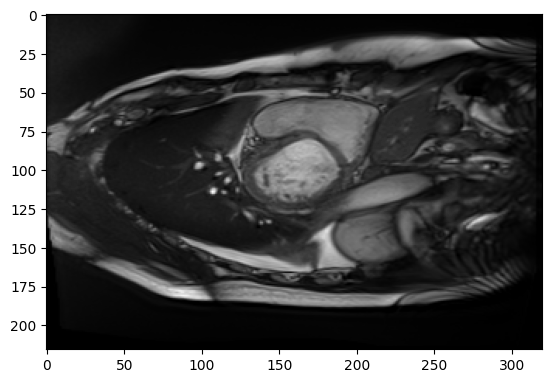

In [8]:
plt.imshow(image[:,:,1],cmap = "gray")

In [5]:
image.shape

(216, 320, 12)

In [6]:
def show_points(coords, labels, ax, marker_size=10):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='green', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red', linewidth=1.25)   

import random
def sam_input(gt_image, label: int, n_points: int, input_image = np.array([None]), pixel_values = range(256)):
    '''
    Generates an array of a defined number of sampled points from one class of the gt_image.

    Arguments:
    gt_image: 2D-array, assigned labels of the original image
    label: integer, class to which the sam_points should belong
    n_points: number of points that should be returned
    input_image: array of input image for checking pixel values
    pixel_values: a range of pixel values that sam_points should have
    Returns:
    A numpy array of n points belonging to the label
    '''
    if input_image.any() != None:
        minimum = min(pixel_values)
        maximum = max(pixel_values)
        arr = np.where(gt_image == label,input_image,0)
        rows,cols = np.where((minimum <= arr) & (maximum >= arr))
        points = [[col, row] for row, col in zip(rows,cols)]

    else:
        rows,cols = np.where(gt_image == label)
        points = [[col, row] for row, col in zip(rows,cols)]
    assert len(points) >= n_points, f"Choose the number of points lower than {len(points)}"
    sam_points = np.array(random.sample(points, n_points))
    return sam_points

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


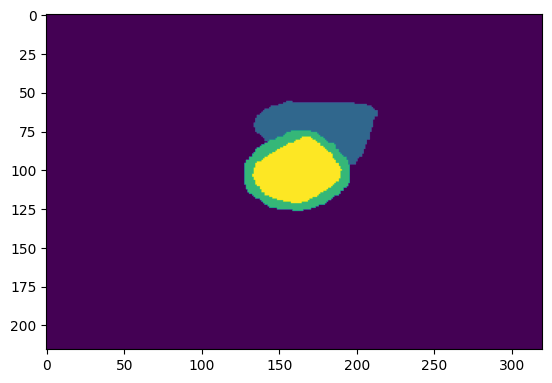

In [7]:
f1 = gzip.GzipFile(os.path.join(path,"patient001_frame01_gt.npy.gz"), "r")
gt_image = np.load(f1)
plt.imshow(gt_image[:,:,1])

In [8]:
num = 5
points_1 = sam_input(gt_image[:,:,1],1,num)
points_2 = sam_input(gt_image[:,:,1],2,num)
points_3 = sam_input(gt_image[:,:,1],3,num)
points = [points_1,points_2,points_3]
masks = []
#for ind in range(3):
print(points_1)
print(points_2)
print(points_3)

[[211  64]
 [182  67]
 [206  60]
 [203  76]
 [152  63]]
[[172  76]
 [159  80]
 [179 120]
 [131 115]
 [140  88]]
[[159 119]
 [135 108]
 [136 106]
 [163 107]
 [156 115]]


In [9]:
masks = np.zeros((image.shape[2],3,image.shape[0],image.shape[1]))
for i in range(1,image.shape[2]):
    print(i)
    img = cv2.cvtColor(image[:,:,i],cv2.COLOR_GRAY2RGB)
    sam_img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    sam_img = sam_img.astype(np.uint8)
    num = 5
    try:
        points_1 = sam_input(gt_image[:,:,i],1,num)
        points_2 = sam_input(gt_image[:,:,i],2,num)
        points_3 = sam_input(gt_image[:,:,i],3,num)
        input_points = np.concatenate((points_1,points_2,points_3))
        predictor = SamPredictor(sam)
        predictor.set_image(sam_img)
        image_embedding = predictor.get_image_embedding()
        for j in range(3):
            print(j)
            input_labels = np.zeros(num * 3)
            input_labels[j*num:(j+1)*num] = 1
            mask, scores, logits = predictor.predict(
                                                            point_coords=input_points,
                                                            point_labels=input_labels,
                                                            multimask_output=False
                                                        )
            masks[i,j,:,:] = mask
            mask = mask.astype(int)
        masks.append(masks)
    except:
        pass

1
0
1
2
2
0
1
2
3
0
1
2
4
0
1
2
5
0
1
2
6
0
1
2
7
0
1
2
8
0
1
2
9
0
1
2
10
0
1
2
11
0
1
2


In [14]:
mask = masks[1,2,:,:]

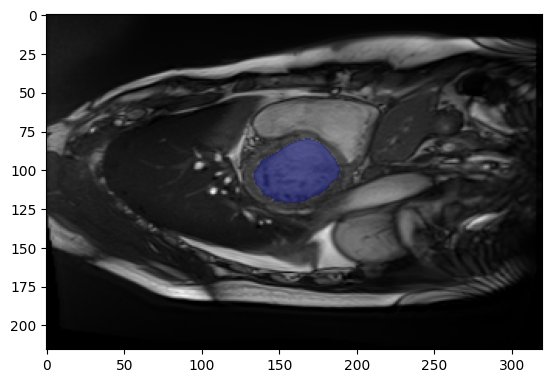

In [15]:
plt.imshow(image[:,:,1],cmap = "gray")
show_mask(mask, plt.gca(),random_color = True)
plt.axis('on')
plt.show()

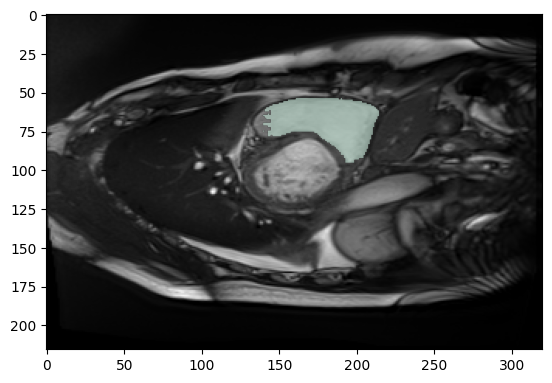

In [16]:
plt.imshow(image[:,:,1],cmap = "gray")
show_mask(masks[1,0,:,:], plt.gca(),random_color = True)
plt.axis('on')
plt.show()

In [17]:
points = np.concatenate((points_1,points_2,points_3))
points.shape

(15, 2)

In [18]:
mask_img = np.empty(shape= (image.shape[2],3,image.shape[0],image.shape[1]),dtype = int)

In [19]:
mask_img.shape

(12, 3, 216, 320)

In [20]:
mask_img[2,0,:,:] = np.ones((216,320))

In [21]:
mask_img[2,0,:,:]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [22]:
gt_image[gt_image[:,:,1] != 0]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 2., 3., ..., 2., 0., 0.],
       [0., 2., 3., ..., 2., 0., 0.],
       [0., 2., 3., ..., 2., 0., 0.]])

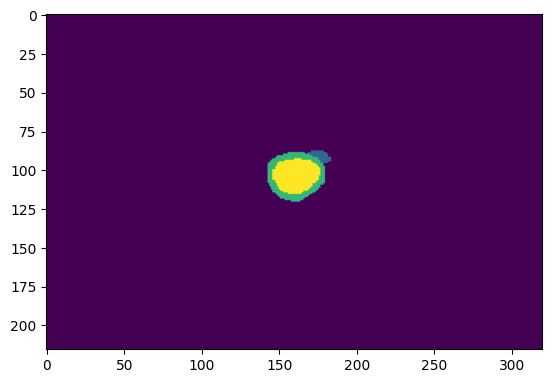

In [23]:
plt.imshow(gt_image[:,:,11])

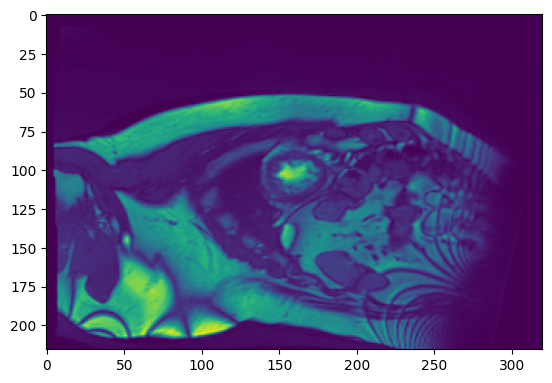

In [24]:
plt.imshow(image[:,:,11])

## Torch metrics

In [100]:
from torch import tensor
from torchmetrics.classification import BinaryJaccardIndex
scores = torch.zeros([3,gt_image.shape[2]], device = "cuda:0")
for i in range(gt_image.shape[2]):
    for j in range(3):
        pred = tensor(masks[i,j,:,:])
        target = tensor(np.where(gt_image[:,:,i]== j + 1,1,0))
        metric = BinaryJaccardIndex()
        score = metric(pred, target)
        scores[j,i] = score
filter_score = scores[scores.isnan() == False]
filter_score = filter_score.reshape([3,int(len(filter_score)/3)])
filter_score
mean_score1 = filter_score[0,:].mean()
        

In [94]:
filter_score = scores[scores.isnan() == False]
filter_score = filter_score.reshape([3,11])

In [96]:
filter_score

tensor([[0.8152, 0.8586, 0.8918, 0.8536, 0.8322, 0.7522, 0.5193, 0.3558, 0.5037,
         0.4241, 0.4200],
        [0.2944, 0.4162, 0.2256, 0.5827, 0.6047, 0.1237, 0.0967, 0.1829, 0.3327,
         0.3297, 0.0481],
        [0.9433, 0.9231, 0.9542, 0.9563, 0.9311, 0.9438, 0.8271, 0.8519, 0.9218,
         0.6122, 0.8658]], device='cuda:0')

### Multiple probabilities

In [2]:
import sys
#os.chdir("/Users/Thanh/master/Visualization_lab/sam-lab")
sys.path.append("..")
from functions.preprocess import preprocess_image
from functions.sam_functions import (
    get_logits,
    get_masks,
    multiclass_prob,
    sample_from_class,
    show_mask,
)

In [3]:
img = cv2.cvtColor(image[:,:,1],cv2.COLOR_GRAY2RGB)
sam_img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
sam_img = sam_img.astype(np.uint8)
predictor = SamPredictor(sam)
predictor.set_image(sam_img)

NameError: name 'cv2' is not defined

In [17]:
n_points = 50
prompts = []
for label in [1, 2, 3]:
    prompts.append(sample_from_class(gt_image[:,:,1], label, n_points=n_points))
logits = get_logits(prompts, predictor)
multi_class = multiclass_prob(logits, hard_labels=True)

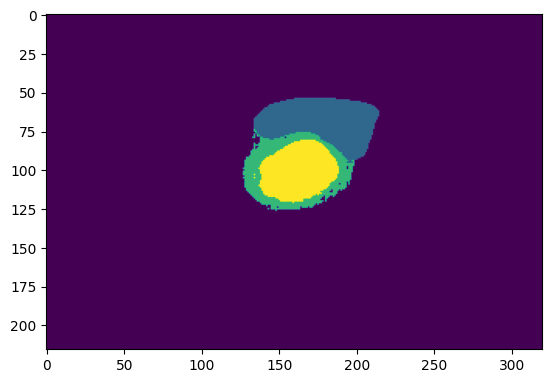

In [24]:
plt.imshow(multi_class)

In [13]:
import sys
sys.path.append("..")
from functions.pipeline import generate_mask_sing_prts,Jaccard_score,gzip_file,generate_mask_mul_prts

ModuleNotFoundError: No module named 'functions'

In [12]:
import os
#os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/preprocess/patient001")
os.chdir("/home/stud/nguyenp0/database/preprocess/patient001")
image = gzip_file("patient001_frame01.npy.gz","r")
gt_image = gzip_file("patient001_frame01_gt.npy.gz","r")

NameError: name 'gzip_file' is not defined

In [3]:
mask_sing= generate_mask_sing_prts(image,gt_image,5)

In [89]:
mask_sing.shape

(216, 320, 12)

In [6]:
import matplotlib.pyplot as plt
#plt.imshow(mask_sing[:,:,4])

In [7]:
mask_mul = generate_mask_mul_prts(image,gt_image,5,5,5)

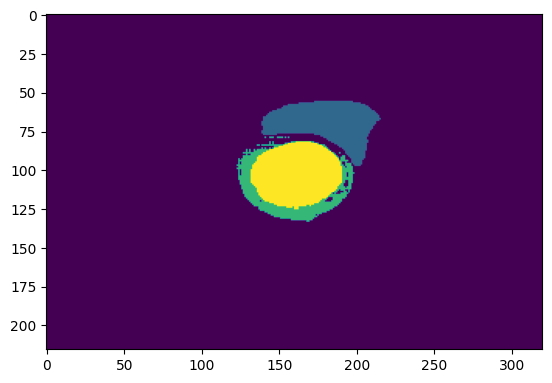

In [8]:
import matplotlib.pyplot as plt
plt.imshow(mask_mul[:,:,3])

In [15]:
import numpy as np
np.unique(mask_mul[:,:,3])

array([0., 1., 2., 3.])

In [9]:
mean_score = Jaccard_score(mask_mul,gt_image)

In [10]:
print(mean_score)

[0.681, 0.419, 0.866]


In [112]:
from torch import tensor
import torch
from torchmetrics.classification import Dice
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassAccuracy
def Dice_score(masks, ground_truth):
    """Generate IoU score for the predicted mask for each class

    Args:
        masks (NDArray): H x W x Z mask containing annotation for class 1,2,3
        ground_truth (NDArray): H x W x Z ground containing annotation for class 1,2,3

    Returns:
        list: list of mean IoU score for class 0,1, 2, 3 consecutively
    """
    # Generate an empty tensor with C x Z with C as number of classes, Z as number of stacks
    scores = torch.zeros([ground_truth.shape[2],4], device = "cuda:0")
    for i in range(ground_truth.shape[2]):
        pred = tensor(masks[:,:,i])
        target = tensor(ground_truth[:,:,i])
        metric = MulticlassF1Score(num_classes=4, average = None)
        score = metric(pred, target)
        scores[i,:] = score
    # Filter for rows with scores > 0 for three masks
    filter_score = scores[(scores[:,1] > 0) & (scores[:,2] > 0) & (scores[:,3] > 0)]
    print(filter_score)
    mean_scores = []
    for j in range(4):
        mean_score = round(float(filter_score[:,j].mean()),3)
        mean_scores.append(mean_score)
    return mean_scores

def accuracy_score(masks, ground_truth):
    """Generate IoU score for the predicted mask for each class

    Args:
        masks (NDArray): H x W x Z mask containing annotation for class 1,2,3
        ground_truth (NDArray): H x W x Z ground containing annotation for class 1,2,3

    Returns:
        list: list of mean IoU score for class 0,1, 2, 3 consecutively
    """
    # Generate an empty tensor with C x Z with C as number of classes, Z as number of stacks
    scores = torch.zeros([ground_truth.shape[2],4], device = "cuda:0")
    for i in range(ground_truth.shape[2]):
        pred = tensor(masks[:,:,i])
        target = tensor(ground_truth[:,:,i])
        mca = MulticlassAccuracy(num_classes=4, average=None)
        score = mca(pred, target)
        scores[i,:] = score
    # Filter for rows with scores > 0 for three masks
    filter_score = scores[(scores[:,1] > 0) & (scores[:,2] > 0) & (scores[:,3] > 0)]
    mean_scores = []
    for j in range(4):
        mean_score = round(float(filter_score[:,j].mean()),3)
        mean_scores.append(mean_score)
    return mean_scores

In [111]:
mean = accuracy_score(mask_mul,gt_image)
mean

[0.996, 0.96, 0.506, 0.88]

In [107]:
mean2 = Jaccard_score(mask_mul,gt_image)

In [113]:
mean3 = Dice_score(mask_mul, gt_image)

tensor([[0.9939, 0.9343, 0.5840, 0.9450],
        [0.9948, 0.9267, 0.7591, 0.9631],
        [0.9944, 0.9344, 0.6808, 0.9637],
        [0.9955, 0.9361, 0.7570, 0.9763],
        [0.9949, 0.9108, 0.6890, 0.9654],
        [0.9937, 0.8631, 0.5450, 0.9559],
        [0.9941, 0.7189, 0.7118, 0.9411],
        [0.9914, 0.5691, 0.2055, 0.9052],
        [0.9924, 0.7789, 0.4194, 0.8384],
        [0.9941, 0.5451, 0.4698, 0.8019],
        [0.9975, 0.5943, 0.4873, 0.9287]], device='cuda:0')


In [5]:
from torch import tensor
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryAccuracy
target = tensor([1, 1, 0, 0])
preds = tensor([0, 1, 1, 0])
def score(f,preds,target):
    metric = f()
    return metric(preds, target)

In [6]:
score(BinaryAccuracy,preds,target)

tensor(0.5000)

## Debug generate_embeddings

In [14]:
import os
import numpy as np
import nibabel as nib
import sys
import glob
import gzip
from segment_anything import SamPredictor, sam_model_registry
import torch
import numpy as np
from segment_anything.modeling import Sam
from typing import Optional, Tuple
from segment_anything.utils.transforms import ResizeLongestSide
sys.path.append("..")
from functions.pipeline import generate_mask_sing_prts,Jaccard_score,gzip_file,generate_mask_mul_prts

In [43]:
class modifiedPredictor((SamPredictor)):
    def __init__(self,sam_model: Sam,image_embedding, input_size, original_size):
        super().__init__(sam_model)
        self.transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        self.features = image_embedding
        self.is_image_set = True
        self.input_size = input_size
        self.original_size = original_size

In [33]:

image = gzip_file("/Users/Thanh/master/Visualization_lab/SAM/database/preprocess/patient001/patient001_frame01.npy.gz","r")
gt_image = gzip_file("/Users/Thanh/master/Visualization_lab/SAM/database/preprocess/patient001/patient001_frame01_gt.npy.gz","r")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Thanh/master/Visualization_lab/SAM/database/preprocess/patient001/patient001_frame01.npy.gz'

In [27]:
from functions.sam_functions import sample_from_class

In [28]:
prompts = sample_from_class(gt_image[:,:,7], 1, 5)

In [29]:
img = cv2.cvtColor(image[:,:,7],cv2.COLOR_GRAY2RGB)
sam_img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
sam_img = sam_img.astype(np.uint8)
predictor = SamPredictor(sam)
predictor.set_image(sam_img)

In [33]:
embedding = predictor.get_image_embedding()
input_size = predictor.input_size
print(input_size)

(691, 1024)


In [44]:
pred = modifiedPredictor(sam,embedding,input_size,image.shape[:2])

In [45]:
mask, scores, logits = pred.predict(
                                                            point_coords=prompts,
                                                            point_labels=np.array([1,1,1,1,1]),
                                                            multimask_output=False
                                                        )

In [46]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

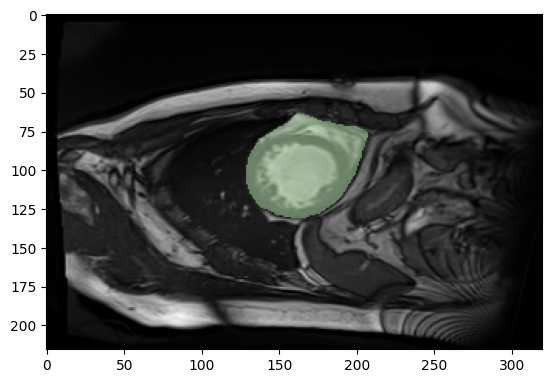

In [47]:
plt.imshow(image[:,:,7],cmap = "gray")
show_mask(mask, plt.gca(),random_color = True)
plt.axis('on')
plt.show()

## Dataset and Dataloader

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import gzip
import numpy as np

def gzip_file(file,mode,image = False):
    f = gzip.GzipFile(file,mode)
    if mode == "r":
        in_image = np.load(f)
        return in_image
    elif mode == "w":
        np.save(file,image)

class CustomData(Dataset):
    def __init__(self, path, debug = False):
        self.path = path
        self.get_data(debug)
    
    def get_data(self,debug = False):
        data = gzip_file(os.path.join(self.path,"ground_truth.npy.gz"),"r")
        if debug:
            self.data = data[:50]
        else:
            self.data = data
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Create a DataLoader instance
data_loader = DataLoader(dataset=CustomData("/Users/Thanh/master/Visualization_lab/SAM/database/preprocess", True), batch_size=10, shuffle=False)

# Iterate through the DataLoader for batch processing
for batch in data_loader:
    # Your training/validation/inference steps using the batched data
    print("Batch Data Shape:", batch[0].shape)
    print("Batch Size:", len(batch))


Batch Data Shape: torch.Size([256, 216])
Batch Size: 10
Batch Data Shape: torch.Size([256, 216])
Batch Size: 10
Batch Data Shape: torch.Size([256, 216])
Batch Size: 10
Batch Data Shape: torch.Size([256, 216])
Batch Size: 10
Batch Data Shape: torch.Size([256, 216])
Batch Size: 10


## Generate frompts

In [18]:
import sys
sys.path.append("..")
from functions.sam_functions import sample_from_class, multiclass_prob
from functions.generate_embeddings import modifiedPredictor,sam,SamPredictor
def generate_masks(embedding,ground_truth,num_class1,num_class2,num_class3, negative_prompt = False):
    predictor = modifiedPredictor(embedding,(1024, 864),(256,216))
    classes = [1,2,3]
    num_prompts = [num_class1,num_class2,num_class3]
    for idx, n in enumerate(num_prompts):
        if len(ground_truth[ground_truth == (idx + 1)])< n:
               num_prompts[idx] == len(ground_truth[ground_truth == (idx + 1)])
    masks = []
    prompts = {1:[],2:[],3:[]}
    for c in classes:
        if c in np.unique(ground_truth):
            prompts[c] = sample_from_class(ground_truth, c, num_prompts[c-1])
    for c in classes:
        if c in np.unique(ground_truth):
            labels = {1:[],2:[],3:[]}
            labels[c] = [1]*num_prompts[c-1]
            if negative_prompt:
                input_points = np.concatenate(list(prompts.values()),axis = 0)
                for nc in classes:
                    if nc != c:
                        labels[nc] = [0] * num_prompts[nc - 1]
            else:
                input_points = prompts[c]
            prmt_labels = np.concatenate(list(labels.values()))
            print(prmt_labels)
            mask, _, _ = predictor.predict(point_coords=input_points,\
                                                    point_labels=prmt_labels,\
                                                    multimask_output=False,\
                                                    return_logits=True)
        else:
            mask = np.fill((256,216),-7)
        masks.append(mask)
    final_mask = multiclass_prob(masks, hard_labels=True)
    return final_mask

        



In [11]:
image = gzip_file("/Users/Thanh/master/Visualization_lab/SAM/database/preprocess/images.npy.gz","r")
gt= gzip_file("/Users/Thanh/master/Visualization_lab/SAM/database/preprocess/ground_truth.npy.gz","r")

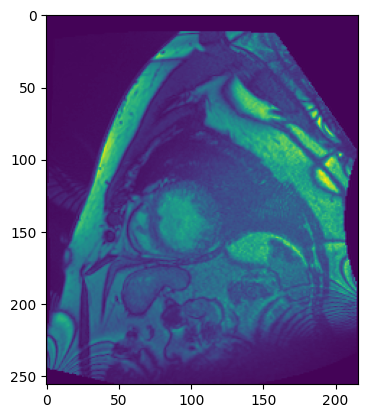

In [34]:
import matplotlib.pyplot as plt
plt.imshow(image[2000,:,:])

In [14]:
image[1,:,:].shape

(256, 216)

In [15]:
import cv2
img = cv2.cvtColor(image[1,:,:],cv2.COLOR_GRAY2RGB)
sam_img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
sam_img = sam_img.astype(np.uint8)
predictor = SamPredictor(sam)
predictor.set_image(sam_img)
embedding = predictor.get_image_embedding()


In [17]:
predictor.input_size

(1024, 864)

In [35]:
mask = generate_masks(embedding,gt[1,:,:],1,1,1, negative_prompt=True)

[1 0 0]
[0 1 0]
[0 0 1]


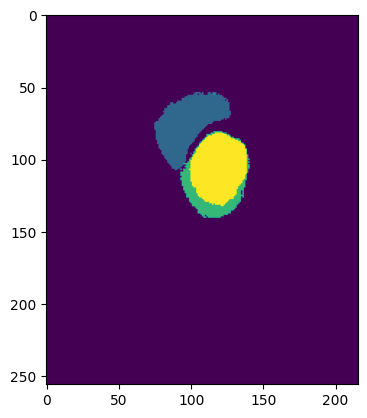

In [36]:
plt.imshow(mask)

## Test pipeline.py

In [1]:
import os
import sys
sys.path.append("..")
from functions.pipeline import *

In [2]:
dataloader = get_batch("/home/stud/nguyenp0/sam-lab/ACDC",10, debug = True)

In [5]:
for embedding,ground_truth in dataloader:
    print(f"Shape of embedding: {embedding.shape}")
    print(f"Shape of ground_truth: {ground_truth.shape}")

Shape of embedding: torch.Size([10, 256, 64, 64])
Shape of ground_truth: torch.Size([10, 256, 216])
Shape of embedding: torch.Size([10, 256, 64, 64])
Shape of ground_truth: torch.Size([10, 256, 216])
Shape of embedding: torch.Size([10, 256, 64, 64])
Shape of ground_truth: torch.Size([10, 256, 216])
Shape of embedding: torch.Size([10, 256, 64, 64])
Shape of ground_truth: torch.Size([10, 256, 216])
Shape of embedding: torch.Size([10, 256, 64, 64])
Shape of ground_truth: torch.Size([10, 256, 216])


In [3]:
embedding,ground_truth = next(iter(dataloader))
mp = modifiedPredictor(embedding[0,:,:,:],(1024, 864),(256,216))

In [21]:
prompts = torch.zeros((5,1,2),dtype = float, device = torch.device("cuda:0"))
prompts

tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]], device='cuda:0', dtype=torch.float64)

In [61]:
prompts1 = []
for i in range(5):
    prompt = sample_from_class(ground_truth[0],1,1)
    prompts1.append(prompt)
prompts = np.array(prompts1)
#prompts = mp.transform.apply_coords(prompts1, mp.original_size)
type(prompts)

numpy.ndarray

In [5]:
label = np.ones((5,1))
label.shape

(5, 1)

In [62]:
mp.predict2(embedding[0:5,:,:,:],prompts,label)

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [60]:
mp.model.prompt_encoder.input_image_size

(1024, 1024)

In [16]:
prompts.shape

(5, 1, 2)

In [17]:
prompts = torch.as_tensor(prompts, dtype = torch.float, device = torch.device("cuda:0"))
label = torch.ones((5,1), dtype = torch.int, device = torch.device("cuda:0"))

In [87]:
prompts.shape

torch.Size([5, 1, 2])

In [90]:
embedding.shape

torch.Size([10, 256, 64, 64])

In [29]:
prompts2 = prompts[None,:,:]
labels2 = label[None,:,:]

In [33]:
points = (prompts,label)
sparse_embeddings, dense_embeddings = mp.model.prompt_encoder(
            points=points,
            boxes=None,
            masks=None,
        )

In [34]:
sparse_embeddings.shape

torch.Size([5, 2, 256])

In [35]:
image_pe = mp.model.prompt_encoder.get_dense_pe()
image_pe.shape

torch.Size([1, 256, 64, 64])

In [11]:
mp.model.prompt_encoder.embed_dim

256

In [12]:
mp.model.prompt_encoder.image_embedding_size

(64, 64)

In [24]:
mp.predict(embedding[0,:,:,:], image_pe, sparse_embeddings, dense_embeddings, multimask_output=False)

AttributeError: 'Tensor' object has no attribute 'astype'

In [59]:
mask, _,_ = mp.model.mask_decoder(embedding[0,:,:,:],image_pe, sparse_embeddings, dense_embeddings, multimask_output=False)

RuntimeError: The size of tensor a (1280) must match the size of tensor b (256) at non-singleton dimension 1

In [49]:
output_tokens = torch.cat([mp.model.mask_decoder.iou_token.weight, mp.model.mask_decoder.mask_tokens.weight], dim=0)

In [50]:
output_tokens.shape

torch.Size([5, 256])

In [51]:
output_tokens = output_tokens.unsqueeze(0).expand(sparse_embeddings.size(0), -1, -1)
tokens = torch.cat((output_tokens, sparse_embeddings), dim=1)

In [52]:
tokens.shape

torch.Size([5, 7, 256])

In [58]:
src = torch.repeat_interleave(embedding[0,:,:,:], tokens.shape[0], dim=0)
src.shape

torch.Size([1280, 64, 64])

In [114]:
sparse_embeddings.shape

torch.Size([5, 2, 256])